# Week1

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

## 載入資料

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-25 03:13:55--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  19.1MB/s    in 0.8s    

2021-12-25 03:13:56 (19.1 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2021-12-25 03:13:56--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  15.1MB/s    in 0.7s    

202

In [4]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [5]:
metadata.shape, ratings.shape

((32892, 19), (371345, 4))

In [6]:
metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


In [7]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [8]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [9]:
# drop duplicates rows
metadata_clean = metadata.loc[metadata.astype(str).drop_duplicates().index]

In [11]:
# replace empty value as Nan
metadata_clean.replace('', np.nan, inplace = True)

In [12]:
# clean column `rank`
metadata_clean['rank'] = metadata_clean['rank'].str.replace('&amp;', '&')
metadata_clean['rank'].fillna('0', inplace = True)
metadata_clean['rank_category'] = [re.search('in (.*) \(', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = [re.search('(.*) in .*', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = metadata_clean['rank_num'].str.replace(',', '').astype(float)

In [13]:
# count `rank_category`
metadata_clean.rank_category.value_counts()

Beauty & Personal Care       32015
Grocery & Gourmet Food          37
Health & Household              21
Sports & Outdoors                3
Toys & Games                     3
Clothing, Shoes & Jewelry        2
Baby                             2
Automotive                       1
Tools & Home Improvement         1
Home & Kitchen                   1
Name: rank_category, dtype: int64

In [14]:
# excluding category != 'Beauty & Personal Care'
metadata_clean = metadata_clean[metadata_clean.rank_category == 'Beauty & Personal Care']

In [15]:
# convert `price` to float
metadata_clean['price'].fillna('0', inplace = True)
metadata_clean['price'] = [re.search('\$(.*)', p).group(1) if re.search('\$(.*)', p) != None else None for p in metadata_clean['price']]
metadata_clean['price'] = metadata_clean['price'].str.replace(',', '').astype(float)

In [16]:
metadata_clean.describe()

,fit,tech2,price,rank_num
count,0.0,0.0,11019.000000,3.201500e+04
mean,NaN,NaN,27.942638,1.281157e+06
std,NaN,NaN,53.903673,8.052168e+05
min,NaN,NaN,0.010000,3.500000e+01
25%,NaN,NaN,8.990000,6.783310e+05
50%,NaN,NaN,15.990000,1.129923e+06
75%,NaN,NaN,29.990000,1.741006e+06
max,NaN,NaN,2149.000000,3.481442e+06


In [17]:
metadata_clean.feature.astype(str).nunique() # only 167 rows have value in `feature`

167

In [18]:
# drop useless columns
metadata_clean.drop(
    ['category', 'tech1', 'fit', 'tech2', 'date', 'similar_item', 'feature', 'main_cat', 'rank'], 
    axis = 1, 
    inplace = True
)

In [19]:
metadata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32015 entries, 0 to 32891
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   description      32015 non-null  object 
 1   title            32015 non-null  object 
 2   also_buy         32015 non-null  object 
 3   brand            16627 non-null  object 
 4   also_view        32015 non-null  object 
 5   details          32015 non-null  object 
 6   price            11019 non-null  float64
 7   asin             32015 non-null  object 
 8   imageURL         32015 non-null  object 
 9   imageURLHighRes  32015 non-null  object 
 10  rank_category    32015 non-null  object 
 11  rank_num         32015 non-null  float64
dtypes: float64(2), object(10)
memory usage: 3.2+ MB


## 資料切分

In [20]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## training data EDA

In [21]:
ratings_trainings.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000,2015-02-19
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800,2014-12-18
2,0143026860,A1572GUYS7DGSR,4.0,1407628800,2014-08-10
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000,2013-03-11
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200,2011-12-25


In [22]:
print(f'Total # orders: {ratings_trainings.shape[0]:,}')
print(f'Unique purchased products: {ratings_trainings.asin.nunique():,}')
print(f'Unique purchased users: {ratings_trainings.reviewerID.nunique():,}')
print(f'Time period: {ratings_trainings.DATE.min()} ~ {ratings_trainings.DATE.max()}')

Total # orders: 370,752
Unique purchased products: 32,582
Unique purchased users: 323,489
Time period: 2000-01-10 00:00:00 ~ 2018-08-31 00:00:00


In [23]:
# distribution of overall rating 
ratings_trainings.describe()

,overall,unixReviewTime
count,370752.000000,3.707520e+05
mean,4.112326,1.440588e+09
std,1.361899,6.957707e+07
min,1.000000,9.474624e+08
25%,4.000000,1.416010e+09
50%,5.000000,1.456877e+09
75%,5.000000,1.485389e+09
max,5.000000,1.535674e+09


In [24]:
print(f'Duplicated orders: {ratings_trainings.duplicated().sum():,}')  
# if item_amount > 1 in one order then would be duplicated?

Duplicated orders: 9,070


In [26]:
# Distribution of rating 
ratings_trainings.overall.value_counts()

5.0    229199
4.0     52610
1.0     39180
3.0     29512
2.0     20251
Name: overall, dtype: int64

Text(0.5, 1.0, 'Distribution of rating')

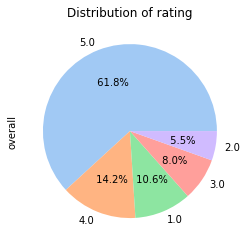

In [27]:
colors = sns.color_palette('pastel')[:5]
ratings_trainings.overall.value_counts().plot.pie(
    y = 'overall', 
    autopct=lambda p:f'{p: .1f}%', # , \n{p*ratings_trainings.shape[0]/100 :,g}
    colors = colors 
)
plt.title('Distribution of rating')

Text(0.5, 1.0, '# order per quarter')

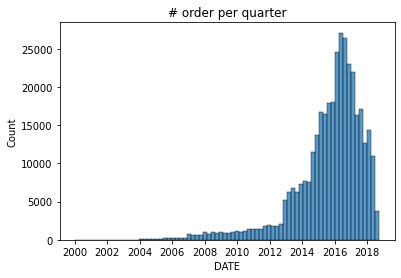

In [28]:
# Distribution of order date
sns.histplot(data = ratings_trainings, x = 'DATE', binwidth = (90)) 
plt.title ('# order per quarter')

In [29]:
# Distribution of # times items were purchased
item_purchased_count = ratings_trainings.groupby(by = 'asin')[['reviewerID']].count()
item_purchased_count.describe()

,reviewerID
count,32582.000000
mean,11.379044
std,97.311099
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,8672.000000


In [30]:
# Distribution of average rating per item
items_avg_rating = ratings_trainings.groupby(by = 'asin')[['overall']].mean()
items_avg_rating.describe()

,overall
count,32582.000000
mean,4.040947
std,1.146113
min,1.000000
25%,3.500000
50%,4.428571
75%,5.000000
max,5.000000


Text(0.5, 1.0, 'Distribution of average rating')

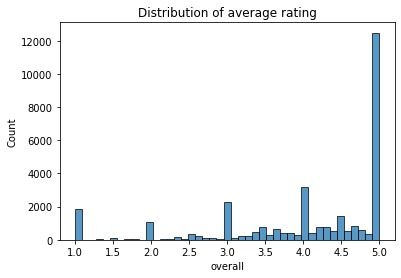

In [31]:
sns.histplot(data = items_avg_rating, x = 'overall')
plt.title('Distribution of average rating')

In [32]:
# Average # items purchased per user
user_avg_items = ratings_trainings.groupby(by = 'reviewerID')[['overall']].count()
user_avg_items.describe()

,overall
count,323489.000000
mean,1.146104
std,0.506657
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,27.000000


(0.0, 300.0)

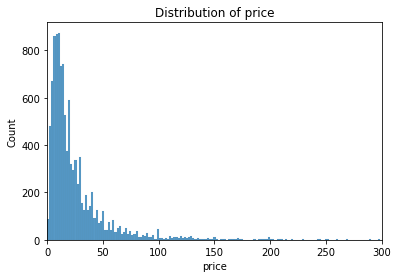

In [33]:
# Distribution of items' price
sns.histplot(data = metadata_clean, x = 'price')
plt.title('Distribution of price')
plt.xlim(0, 300)

In [34]:
# Distribution of # items of each brand
n_items_brand = metadata_clean.groupby('brand')[['asin']].count()
n_items_brand.describe()

,asin
count,7734.000000
mean,2.149858
std,5.107069
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,252.000000


## 產生推薦

### Monthly top seller products only

In [39]:
def recommender_topseller(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    for u in users:
        ## Best seller (by rating data) & highest rating products (recommand `k` product)
        products_rating = training_data[training_data.DATE >= '2018-08-01'].groupby('asin')[['overall']].agg(['mean', 'count'])
        products_rating.columns = products_rating.columns.droplevel(0)
        best_seller_lst = products_rating.reset_index().sort_values(by = ['count', 'mean'], ascending = False).iloc[:k, 0].tolist()
            
        recommendations[u] = best_seller_lst
    
    return recommendations

ratings_by_user_topseller = recommender_topseller(ratings_trainings, users)
# ratings_by_user

## Order history + rank + rating + topseller

- if purchased, at most 50% recommanded items are based on purchased items: 
    - using variables: `also_view`, `also_buy`
    - by rating_data, check if others users review this purchased items and others items 
    - same brand
- if purchased, the other 50% / if not purchased, all the recommanded items:
    - 10% for the highest ranking items
    - 20% for the highest rating and sales items
    - 70% for the topsellers

In [36]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    for u in users:
        # purchased before
        user_recom = []

        if u in training_data['reviewerID'].values:
            
            # recommand `k1` products
            k1 = min(sum(training_data.reviewerID == u) * 3, 5)
            items_purchase = training_data.loc[training_data.reviewerID == u, 'asin'].values
            
            for i in items_purchase:

                # item i's `also_buy` 
                also_buy_lst = metadata_clean.loc[metadata_clean.asin == i, 'also_buy'].values[0]
                user_recom += also_buy_lst
                
                # item i's `also_view`
                also_view_lst = metadata_clean.loc[metadata_clean.asin == i, 'also_view'].values[0]
                user_recom += also_view_lst
                
                # items that others user who review item i also review (by rating data)
                also_review_users_lst = training_data.loc[(training_data.asin == i) & (training_data.reviewerID != u), 'reviewerID'].unique()
                also_review_items_lst = training_data.loc[(training_data.reviewerID.isin(also_review_users_lst)) & (training_data.asin != i), 'asin'].tolist()
                user_recom += also_review_items_lst

                # same brand 
                item_brand = metadata_clean.loc[metadata_clean.asin == i, 'brand'].values[0]
                # print(item_brand)
                # print(pd.isnull(item_brand))
                if pd.isnull(item_brand):
                    smae_brand_lst = metadata_clean.loc[metadata_clean.brand == item_brand, 'asin'].tolist()
                    user_recom += smae_brand_lst

                # at most k1 items from purchase history
                user_recom = user_recom[:k1]
        else:
            k1 = 0
        

        # Popular products (recommand `k_left` products)
        k_left = k - len(user_recom)

        ## Highest rank (recommand `k2` products)
        k2 = round(k_left * 0.1)
        highest_ranking_lst = metadata_clean.sort_values(by = 'rank_num').head(k2)['asin'].tolist()

        ## Highest rating products first and then best seller (recommand `k3` products)
        k3 = round(k_left * 0.2)
        products_rating = training_data.groupby('asin')[['overall']].agg(['mean', 'count'])
        products_rating.columns = products_rating.columns.droplevel(0)
        highest_rating_lst = products_rating.reset_index().sort_values(by = ['mean', 'count'], ascending = False).iloc[:k3, 0].tolist()

        ## Best seller (by rating data) & highest rating products (recommand `k_left - k2 - k3` product)
        best_seller_lst = products_rating.reset_index().sort_values(by = ['count', 'mean'], ascending = False).iloc[:(k_left - k2 - k3), 0].tolist()

        # concat all the item lists
        user_recom = user_recom + highest_ranking_lst + highest_rating_lst + best_seller_lst            
        recommendations[u] = user_recom
    
    return recommendations

ratings_by_user = recommender(ratings_trainings, users)
# ratings_by_user

In [47]:
def recommender_monthly(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    training_data = training_data[training_data.DATE > '2018-08-01'].copy()
    recommendations = {}
    for u in users:
        # purchased before
        user_recom = []

        if u in training_data['reviewerID'].values:
            
            # recommand `k1` products
            k1 = min(sum(training_data.reviewerID == u) * 3, 6)
            items_purchase = training_data.loc[training_data.reviewerID == u, 'asin'].values
            
            for i in items_purchase:

                # item i's `also_buy` 
                also_buy_lst = metadata_clean.loc[metadata_clean.asin == i, 'also_buy'].values[0]
                user_recom += also_buy_lst
                
                # item i's `also_view`
                also_view_lst = metadata_clean.loc[metadata_clean.asin == i, 'also_view'].values[0]
                user_recom += also_view_lst
                
                # items that others user who review item i also review (by rating data)
                also_review_users_lst = training_data.loc[(training_data.asin == i) & (training_data.reviewerID != u), 'reviewerID'].unique()
                also_review_items_lst = training_data.loc[(training_data.reviewerID.isin(also_review_users_lst)) & (training_data.asin != i), 'asin'].tolist()
                user_recom += also_review_items_lst

                # same brand 
                item_brand = metadata_clean.loc[metadata_clean.asin == i, 'brand'].values[0]
                if pd.isnull(item_brand):
                    smae_brand_lst = metadata_clean.loc[metadata_clean.brand == item_brand, 'asin'].tolist()
                    user_recom += smae_brand_lst

                # at most k1 items from purchase history
                user_recom = user_recom[:k1]
        else:
            k1 = 0
        
        # Popular products (recommand `k_left` products)
        k_left = k - len(user_recom)

        ## Highest rank (recommand `k2` products)
        k2 = round(k_left * 0.1)
        highest_ranking_lst = metadata_clean.sort_values(by = 'rank_num').head(k2)['asin'].tolist()

        ## Highest rating products first and then best seller (recommand `k3` products)
        k3 = round(k_left * 0.2)
        products_rating = training_data.groupby('asin')[['overall']].agg(['mean', 'count'])
        products_rating.columns = products_rating.columns.droplevel(0)
        highest_rating_lst = products_rating.reset_index().sort_values(by = ['mean', 'count'], ascending = False).iloc[:k3, 0].tolist()

        ## Best seller (by rating data) & highest rating products (recommand `k_left - k2 - k3` product)
        best_seller_lst = products_rating.reset_index().sort_values(by = ['count', 'mean'], ascending = False).iloc[:(k_left - k2 - k3), 0].tolist()

        # concat all the item lists
        user_recom = user_recom + highest_ranking_lst + highest_rating_lst + best_seller_lst
        recommendations[u] = user_recom
    
    return recommendations

ratings_by_user_monthly = recommender_monthly(ratings_trainings, users)

## 結果評估

In [41]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

In [54]:
# monthly topseller
print(f'Monthly topseller: \n{round(evaluate(ratings_testings_by_user, ratings_by_user_topseller), 4)}')


Monthly topseller: 
0.1576


In [52]:
# all data: 
## At most 50% by order history (basket analysis)
## Others: 10% by product ranking, 20% by product rating & sales, 60% by sales
print(f'Order history + ranking + rating + sales: \n{round(evaluate(ratings_testings_by_user, ratings_by_user), 4)}')

Order history + ranking + rating + sales: 
0.0831


In [53]:
# monthly data: 
## At most 50% by order history (basket analysis)
## Others: 10% by product ranking, 20% by product rating & sales, 60% by sales
print(f'Monthly order history + ranking + rating + sales: \n{round(evaluate(ratings_testings_by_user, ratings_by_user_monthly), 4)}')


Monthly order history + ranking + rating + sales: 
0.1136
